In [1]:
import tensorflow as tf
# from tensorflow.keras.layers import (
#     Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation,
#     BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D)
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam, RMSprop

from keras.layers import (
    Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation,
    BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D)
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy
from keras.layers.merge import _Merge
from functools import partial

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt

np.random.seed(0)
tf.set_random_seed(0)

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Let's train on cars first. Might be more interesting for the case of insurance.
car_label = 1 # Cifar has 1 for automobiles.
horse_label = 7 # Cifar has 7 for horses
bird_label = 2 

train_mask = [y[0] == horse_label for y in y_train]
test_mask = [y[0] == horse_label for y in y_test]

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

assert x_train.shape[0] == y_train.shape[0] # Number of data points is the same.
assert x_test.shape[0] == y_test.shape[0]

x_train = np.concatenate([x_train,x_test],axis=0)
# Centering
x_train = (x_train - 127.5)/127.5

def wasserstein(y_true, y_pred):
    return -K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, interpolated_samples):
    gradients = K.gradients(loss = y_pred,
                            variables = interpolated_samples)[0] # SUSPICIOUS
    gradients_sqr = K.square(gradients) # Euclidean Norm
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis = np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty) # So in the end, just one number.

weight_init = RandomNormal(mean = 0 , stddev = 0.02)

Using TensorFlow backend.


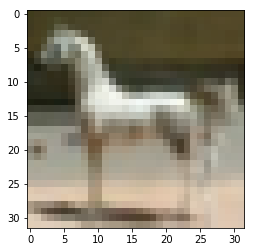

In [2]:
plt.imshow((x_train[150,:,:,:]+1)/2) # Why is there a +1, /2 in the original?

In [3]:
z_dim = 100
batch_size = 128 #64
critic_learning_rate = 0.0005
generator_learning_rate = 0.0005 # Aren't those learning rates too small?
grad_weight = 10
epochs = 6000
n_critic = 5

In [4]:
input_dim = x_train[0].shape

critic_input = Input(shape = input_dim, name = 'critic_input')

x = critic_input
x = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'same', 
           name = 'critic_conv_0', kernel_initializer = weight_init)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same',
           name = 'critic_conv_1', kernel_initializer = weight_init)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same',
           name = 'critic_conv_2', kernel_initializer = weight_init)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',
           name = 'critic_conv_3', kernel_initializer = weight_init)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Flatten()(x)
# No activation

critic_output = Dense(1, activation = None, kernel_initializer = weight_init)(x)

critic = Model(critic_input, critic_output)

In [5]:
generator_initial_dense_layer_size = (4,4,128)
generator_input = Input(shape = (z_dim,), name = 'generator_input')

x = generator_input
x = Dense(np.prod(generator_initial_dense_layer_size),
          kernel_initializer = weight_init)(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Reshape(generator_initial_dense_layer_size)(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_0', kernel_initializer = weight_init)(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 64, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_1', kernel_initializer = weight_init)(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_2', kernel_initializer = weight_init)(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2DTranspose(filters = 3, kernel_size = 5, strides = 1, padding = 'same',
                    name = 'generator_conv_3', kernel_initializer = weight_init)(x)
x = Activation('tanh')(x)
generator_output = x

generator = Model(generator_input, generator_output)

In [6]:
# Adversarial
# Set the generator as unable to train.
# Note to self - any difference between setting the model outright untrainable vs layers
# untrainable

# See this https://github.com/keras-team/keras/blob/master/keras/layers/merge.py
# This means that RandomWeightedAverage should be used as if it was a Merge layer
class RandomWeightedAverage(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1,1,1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    
def gradient_penalty_loss(y_true, y_pred, interpolated_samples):
    gradients = K.gradients(y_pred, interpolated_samples)[0] # Loss first then gradient, no?
    # It should be (loss, variables)??
    gradients_sqr = K.square(gradients) # Euclidean Norm
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis = np.arange(1, len(gradients_sqr.shape))) # Sum over rows
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm) # Lambda is handled during compilation.
    
    return K.mean(gradient_penalty)

###########################
### adversarial compile ###
###########################
generator.trainable = False
for l in generator.layers:
    l.trainable = False
    
# Real image
real_img = Input(shape = input_dim)

# Fake image
z_disc = Input(shape = (z_dim,))
fake_img = generator(z_disc)

# Critic determines validity of real and fake images
fake = critic(fake_img)
valid = critic(real_img)

# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage(batch_size = batch_size)([real_img, fake_img])
validity_interpolated = critic(interpolated_img)

partial_gp_loss = partial(gradient_penalty_loss,
                          interpolated_samples = interpolated_img)
adversarial = Model(inputs = [real_img, z_disc],
                    outputs = [valid, fake, validity_interpolated])

adversarial.compile(
    loss = [wasserstein, wasserstein, partial_gp_loss],
    optimizer = RMSprop(lr = critic_learning_rate),
    loss_weights = [1, 1, grad_weight]
)

#########################
### generator compile ###
#########################
critic.trainable = False
for l in critic.layers:
    l.trainable = False
    
generator.trainable = True
for l in generator.layers:
    l.trainable = True

# You have exactly the same stuff as generator, but at the end you apply the critic.
model_input = Input((z_dim,))
img = generator(model_input)
model_output = critic(img)
generator_model = Model(model_input, model_output)
generator_model.compile(optimizer = RMSprop(lr = generator_learning_rate),
                        loss = wasserstein)

In [7]:
%%time
# Training
d_losses = []
d_gens = []

for epoch in range(1):
    for _ in range(1): # Training the critic
        valid = np.ones((batch_size, 1))
        fake = -np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1))
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)
        d_loss = adversarial.train_on_batch(x = [true_imgs, noise],
                                            y = [valid, fake, dummy])
    # Training the generator
    valid = np.ones((batch_size,1))
    noise = np.random.randint(0, 1, (batch_size, z_dim))
    d_gen = generator_model.train_on_batch(x = noise,
                                           y = valid)
    d_losses.append(d_loss)
    d_gens.append(d_gen)
    
    if epoch % 500 == 0:
        print('Completed epoch {}'.format(epoch))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Completed epoch 0
CPU times: user 4.56 s, sys: 459 ms, total: 5.02 s
Wall time: 4.96 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

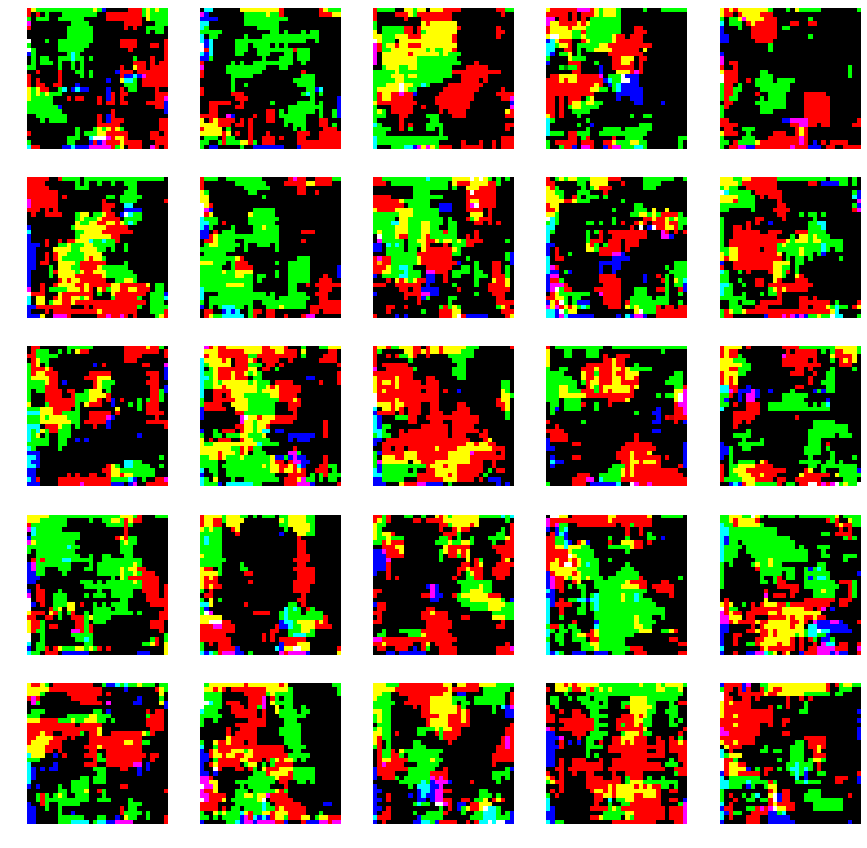

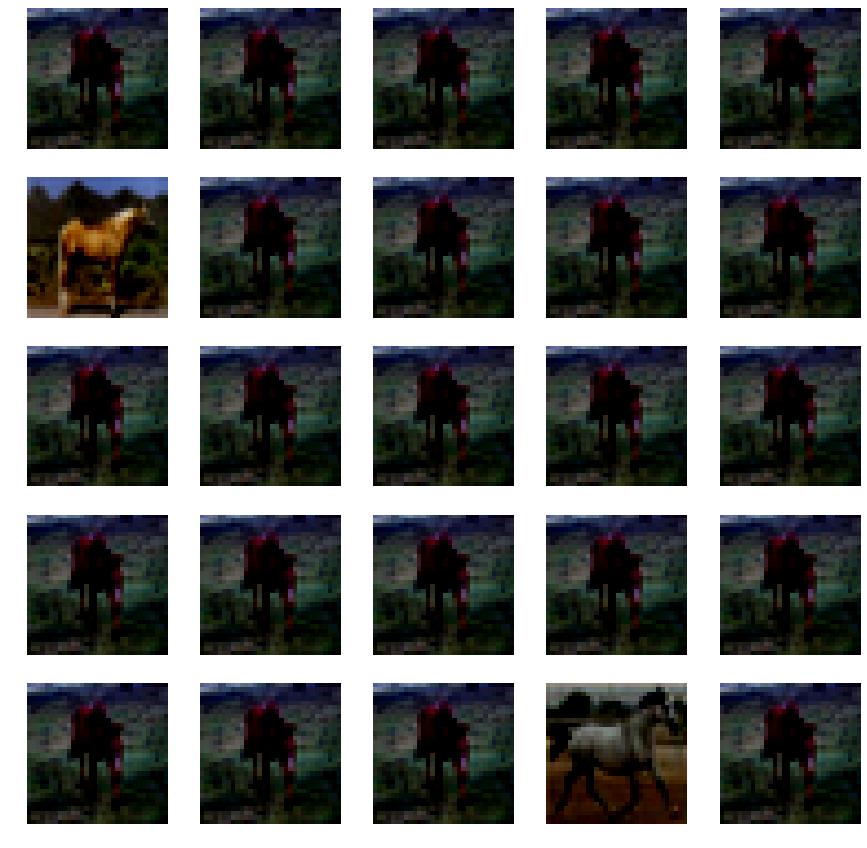

In [12]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, z_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
gen_imgs = np.clip(gen_imgs, 0,1) # Can you simply clip things like this?

fig, axs = plt.subplots(r, c, figsize = (15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
        
fig, axs = plt.subplots(r, c, figsize = (15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train)):
            diff = compare_images(gen_imgs[cnt, :,:,:],k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1